In [1]:
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
plt.rcParams['figure.figsize'] = (18,5)
import pickle
import plotly.express as px
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from joblib import dump, load
import traceback

import warnings
warnings.filterwarnings('ignore')




## Problem Statement

1. **You are diabetic**: This is a direct classification result when the probability of the diabetic class is above a certain threshold, often 0.5 for binary classification. However, this threshold can be adjusted based on the specific needs of the model and the business or medical requirements.

2. **You are not Diabetic**: Similarly, this is another direct classification result when the probability of the non-diabetic class is above the threshold.

3. **You have x% risk to become diabetic**: This is essentially the probability value assigned by the model to the diabetic class for the given entry. For instance, if you input a patient's data into the model and it outputs a probability of 0.65 for the "diabetic" class, it can be interpreted as "This patient has a 65% risk of becoming diabetic."

**Using Selected/Best Model with Probabilities:**

Using the model to predict class probabilities using the `predict_proba` method. This will provide probabilities for each class, and in the context of a binary problem like yours, the output will have two columns: the first column represents the probability of the "non-diabetic" class, and the second represents the probability of the "diabetic" class.

**to utilize models to analyze diabetes and non diabetes patients to find out what are the leading causes for diabetes**


## Features Being Used

Certainly! Here's a brief description of each feature:

1. **gender**: 
    - Represents the biological sex of the individual.
    - Typically categorized as "male," "female," or in some datasets, "other" or "non-binary."

2. **age**: 
    - Represents the age of the individual, usually measured in years.
    - Can be a continuous variable (e.g., 25.5 years) or discrete (e.g., 25 years).

3. **hypertension**: 
    - Indicates whether the individual has hypertension (high blood pressure).
    - It's usually a binary indicator: "yes" (or 1) for those with hypertension, and "no" (or 0) for those without.

4. **heart_disease**: 
    - Indicates whether the individual has any heart-related diseases.
    - Typically a binary feature: "yes" (or 1) for those with heart disease and "no" (or 0) for those without.

5. **smoking_history**: 
    - Describes the individual's history with smoking.
    - Can be categorical, with values such as "never smoked," "formerly smoked," "currently smoking," etc.

6. **bmi**: 
    - Stands for "Body Mass Index."
    - A measure used to determine whether a person has a healthy body weight for their height.
    - Calculated as weight in kilograms divided by the square of height in meters. 
    - Used as an indicator of underweight, normal weight, overweight, or obesity.

7. **HbA1c_level**: 
    - Refers to the Hemoglobin A1c test.
    - Measures the average blood sugar (glucose) level over the past 2-3 months.
    - Used to diagnose diabetes and gauge how well someone is managing their diabetes.
    - Values are often presented as a percentage. A higher percentage can indicate higher blood glucose levels.

8. **blood_glucose_level**: 
    - Represents the concentration of glucose present in the blood.
    - Measured in milligrams per deciliter (mg/dL) or millimoles per liter (mmol/L).
    - A key indicator for diagnosing and monitoring diabetes.

Each of these features provides valuable health-related information. In the context of predicting or understanding diabetes, they are all relevant as they are associated with risk factors or direct indicators of diabetes.

## 1.0 Loading the Model 

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [3]:
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0


## 1.1 EDA 

### 1.1.0 Corrolation Matrix

In [84]:
corr = df.select_dtypes(["int64", "float64"]).corr()
corr

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.257305,0.238451,0.344797,0.106719,0.114317,0.264927
hypertension,0.257305,1.000000,0.119982,0.148111,0.081441,0.084834,0.195710
heart_disease,0.238451,0.119982,1.000000,0.061376,0.068140,0.070832,0.170711
bmi,0.344797,0.148111,0.061376,1.000000,0.084423,0.092543,0.214932
HbA1c_level,0.106719,0.081441,0.068140,0.084423,1.000000,0.171615,0.406408
blood_glucose_level,0.114317,0.084834,0.070832,0.092543,0.171615,1.000000,0.424336
diabetes,0.264927,0.195710,0.170711,0.214932,0.406408,0.424336,1.000000


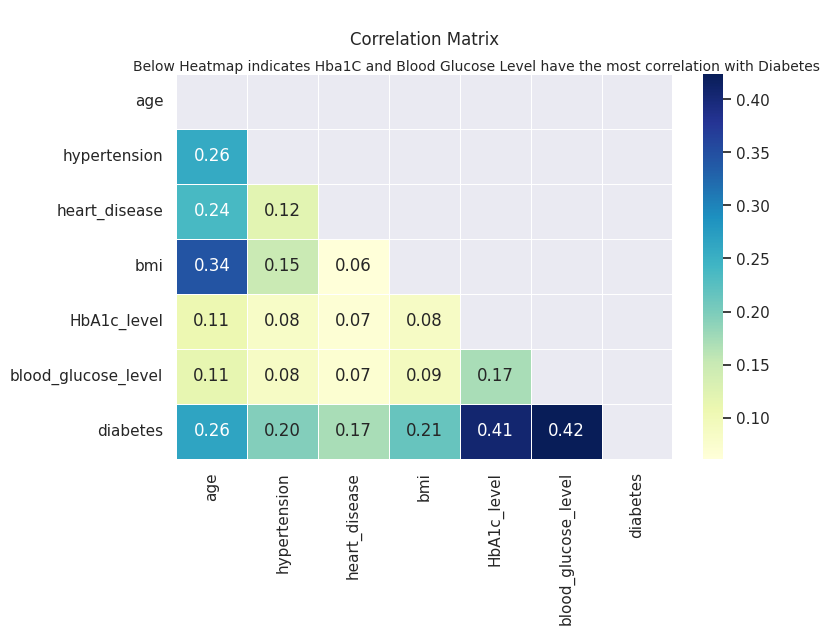

In [102]:
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, mask=mask, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5)
plt.title("\nCorrelation Matrix\n")
fig.text(0.5, 0.88, 'Below Heatmap indicates Hba1C and Blood Glucose Level have the most correlation with Diabetes', ha='center', va='bottom', fontsize=10)
plt.show()

### 1.1.1 Age Univariate and Bivariate Analysis

In [116]:
df.age.describe()

count    96146.000000
mean        41.794326
std         22.462948
min          0.080000
25%         24.000000
50%         43.000000
75%         59.000000
max         80.000000
Name: age, dtype: float64

```
count    96146.000000
mean        41.794326
std         22.462948
min          0.080000
25%         24.000000
50%         43.000000
75%         59.000000
max         80.000000
Name: age, dtype: float64
```

The average age across all the entries is approximately 41.79 years.

3. **std**: The standard deviation, which is a measure of the amount of variation or dispersion in the set of values, is approximately 22.46 years. This suggests that most of the ages lie within 22.46 years above or below the mean age (41.79 years).

4. **min**: The youngest age in the dataset is 0.08 years, which is likely a baby of about a month old (around 29 days).

5. **25% (First Quartile)**: 25% of the people in the dataset are younger than 24 years. This is the age below which a quarter of the data falls.

6. **50% (Median)**: The median age, or the age at which half of the data points are above and half are below, is 43 years.

7. **75% (Third Quartile)**: 75% of the people in the dataset are younger than 59 years. This means that three-quarters of the data falls below this age, and one-quarter of the data is above it.

8. **max**: The oldest age in the dataset is 80 years.


In [138]:
diabete_age = df.groupby("diabetes")[["age"]].mean()

diabete_age.head()

,age
diabetes,
0,39.943229
1,60.925961


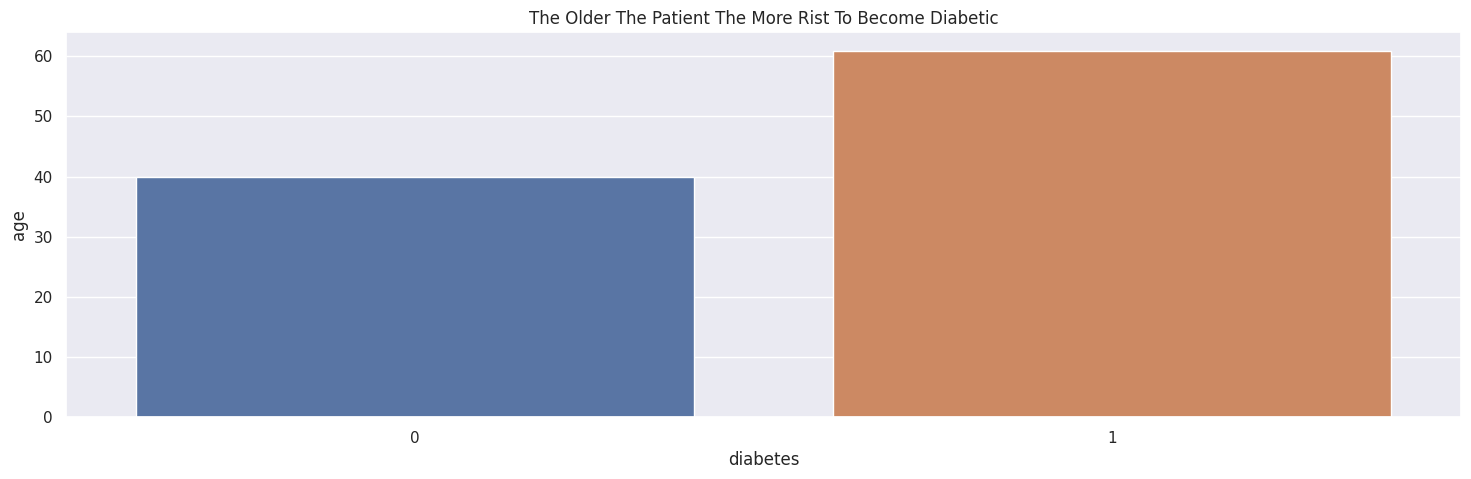

In [144]:
sns.barplot(data=diabete_age, x=diabete_age.index, y="age");
plt.title("The Older The Patient The More Rist To Become Diabetic");

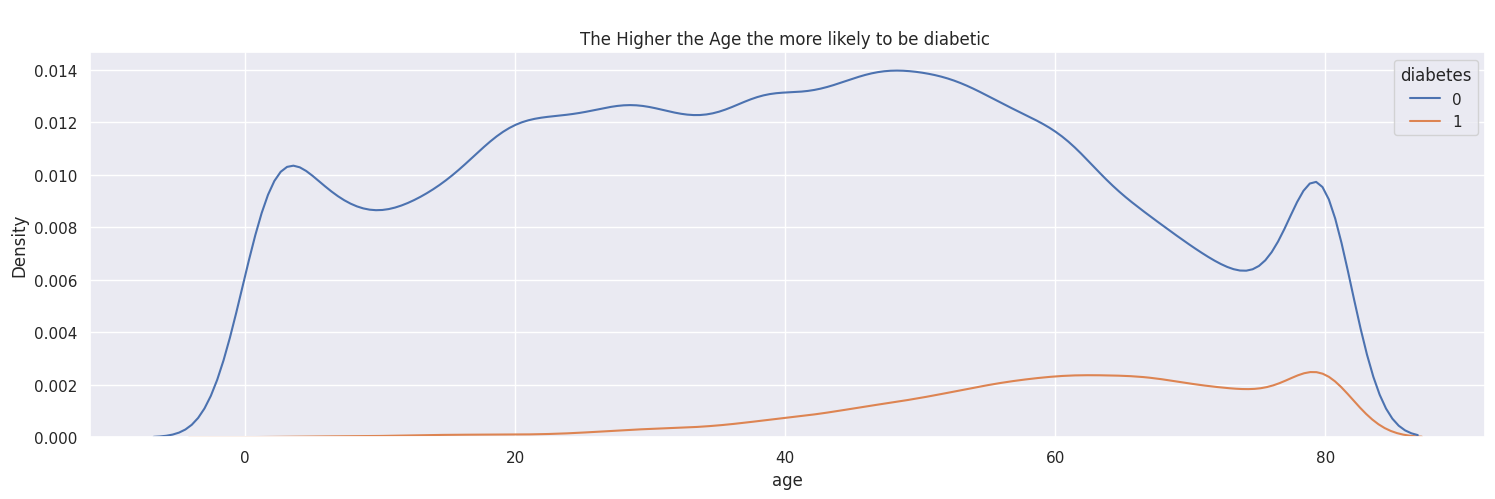

In [118]:
sns.kdeplot(df, x="age", hue="diabetes");
plt.title("\nThe Higher the Age the more likely to be diabetic ");

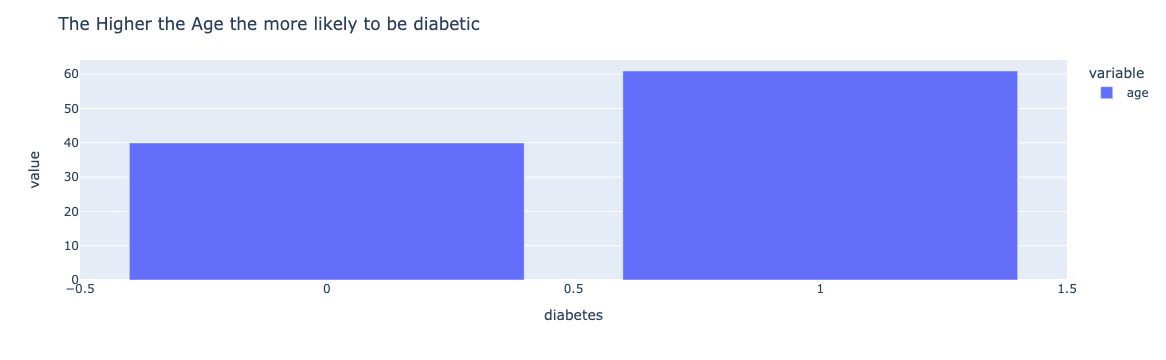

In [119]:
fig = px.bar(diabete_age)

fig.update_layout(title_text="The Higher the Age the more likely to be diabetic")


### 1.1.2 Gender Analysis Univariate and Bivariate 

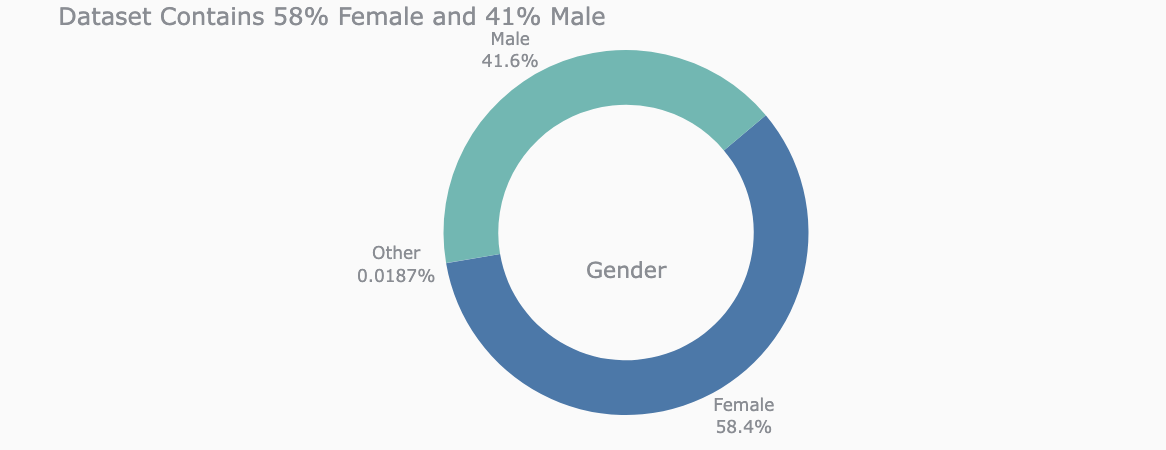

In [149]:
gender_count = df["gender"].value_counts().to_frame()

fig = px.pie(df, names='gender', height=450, width=1200, hole=0.7, 
                   color_discrete_sequence=['#4c78a8', '#72b7b2', '#6b92bc'], title="Dataset Contains 58% Female and 41% Male\n")
fig.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=50)
fig.update_layout(margin=dict(t=50, b=35, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))

fig.add_annotation(dict(x=0.5, y=0.4,  align='center',
                        xref = "paper", yref = "paper",
                        showarrow = False, font_size=22,
                        text="Gender"))

fig.add_layout_image(
    dict(
        source="https://i.imgur.com/3Cab96Z.jpg",
        xref="paper", yref="paper",
        x=0.48, y=0.48,
        sizex=0.3, sizey=0.25,
        xanchor="right", yanchor="bottom", sizing= "contain",
    )
)
fig.add_layout_image(
    dict(
        source="https://i.imgur.com/c6QKoDy.jpg",
        xref="paper", yref="paper",
        x=0.55, y=0.48,
        sizex=0.3, sizey=0.25,
        xanchor="right", yanchor="bottom", sizing= "contain",
    )
)


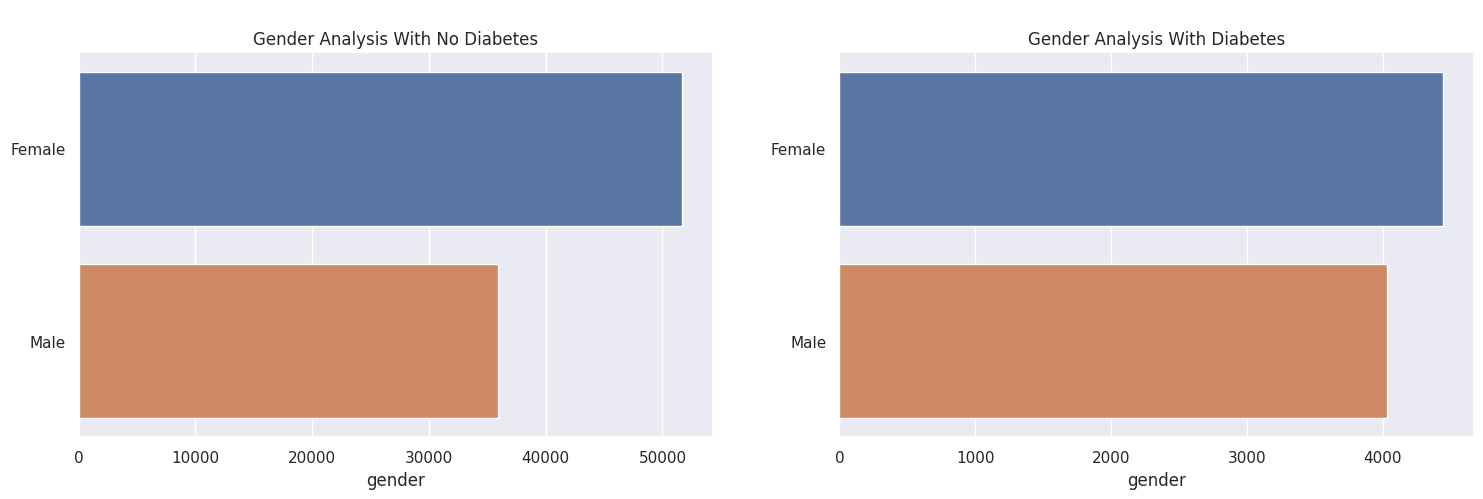

In [106]:
# Plotting the Gender Distribution for Diabetes and Non-Diabetes


gender_count_no_diabetes = df.query("diabetes == 0 & gender != 'Other'")["gender"].value_counts().to_frame()
gender_count_diabetes = df.query("diabetes == 1 & gender != 'Other'")["gender"].value_counts().to_frame()


fig, ax = plt.subplots(nrows=1, ncols=2)


fig1 = sns.barplot(data=gender_count_no_diabetes, y=gender_count_no_diabetes.index, x="gender", ax=ax[0]);
fig1.set_title("\nGender Analysis With No Diabetes");

fig2 = sns.barplot(data=gender_count_diabetes, y=gender_count_diabetes.index, x="gender", ax=ax[1]);
fig2.set_title("\nGender Analysis With Diabetes");


### 1.1.3 Hemoglobin A1c Level Bivariate with Diabetes 

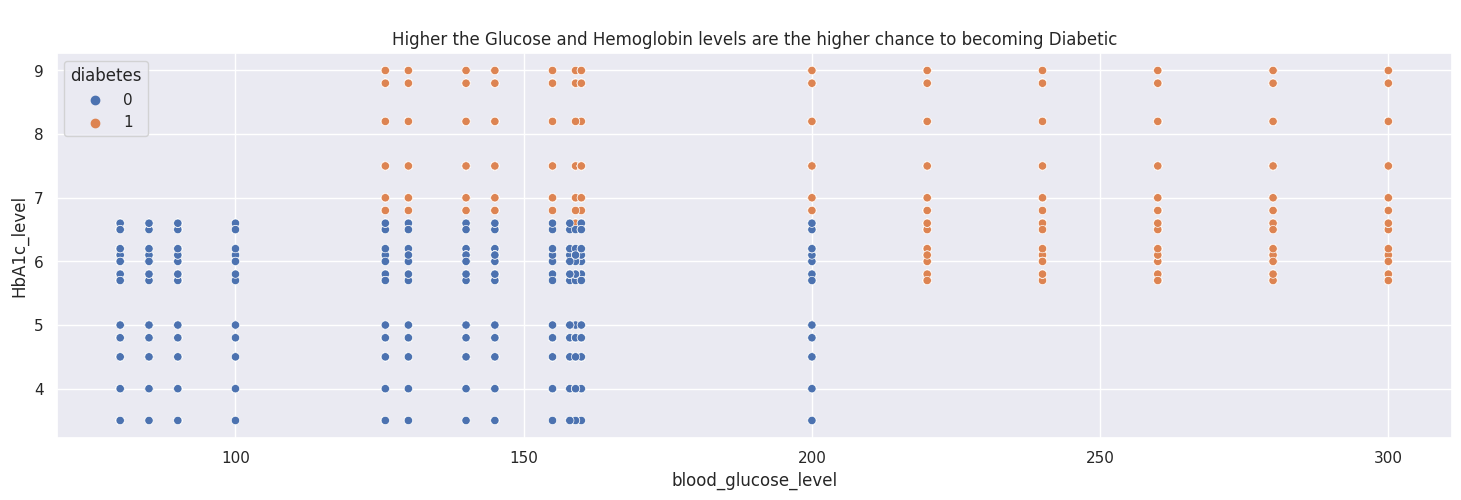

In [107]:
# Scatter Plot of Hemoglobin and Blood Glucose Level 

fig = sns.scatterplot(data=df,y="HbA1c_level", x="blood_glucose_level", hue="diabetes");
fig.set_title("\nHigher the Glucose and Hemoglobin levels are the higher chance to becoming Diabetic");


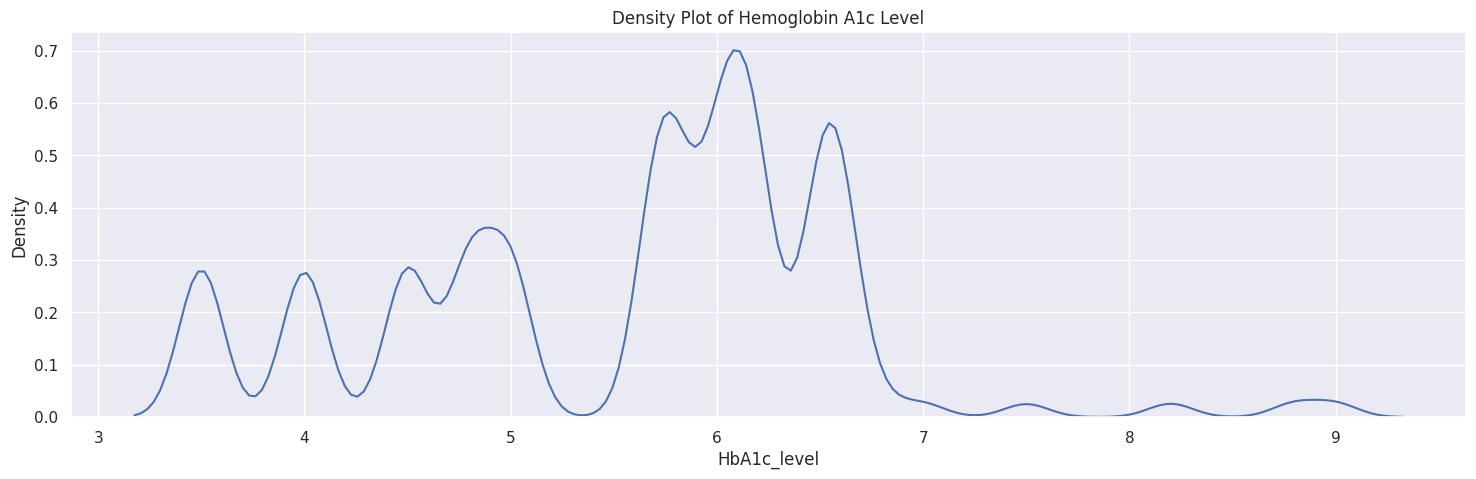

In [151]:
fig = sns.kdeplot(df, x="HbA1c_level");
fig.set_title("Density Plot of Hemoglobin A1c Level");


In [112]:

#
##
###
####
##### Statistical Testing Function 
####
###
##
#

import scipy.stats
def stat_testing(group1, group2):

    t_statistic, p_value = scipy.stats.ttest_ind(group1, group2, equal_var=True)
    
    # Assume heights_group1 and heights_group2 are your data
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)  # ddof=1 for sample standard deviation
    n1, n2 = len(group1), len(group2)
    
    # Calculate the standard error of the difference in means
    std_err_difference = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    # Find the t-critical value for a 95% confidence interval
    alpha = 0.05  # for a 95% confidence interval
    degree_freedom = min(n1, n2) - 1  # degrees of freedom
    t_critical = scipy.stats.t.ppf(1 - alpha / 2., degree_freedom)
    
    # Calculate the margin of error
    margin_of_error = t_critical * std_err_difference
    
    # Calculate the confidence interval
    conf_interval_lower = mean1 - mean2 - margin_of_error
    conf_interval_upper = mean1 - mean2 + margin_of_error
    
    return t_statistic, p_value, [round(conf_interval_lower, 2), round(conf_interval_upper, 2)]




#### T-Test and Finding the Confidence Interval For HbA1c_Level For both Groups of Diabetes and Non-Diabetes 

The results suggest a very strong statistical difference between the two groups:

- **t-statistic**: The t-statistic of approximately 138.28 is very high, which suggests a large difference in the means of the two groups relative to the variability within the groups.

- **p-value**: A p-value of 0.0 is indicative of the results being extremely statistically significant. This means that the likelihood of observing such extreme differences in "HbA1c_level" between the two groups (one with "diabetes" equal to 1 and the other with "diabetes" equal to 0) purely by chance is virtually zero.

Given these results, we would reject the null hypothesis, which assumes that there's no difference between the two groups. This indicates that there is a statistically significant difference in "HbA1c_level" between the group with "diabetes" equal to 1 and the group with "diabetes" equal to 0.

The confidence interval we've calculated suggests that if the underlying population from which your samples are drawn were subject to many additional samples, approximately 95% of those calculated intervals would contain the true difference in means between the two populations.

The 95% confidence interval for the difference in mean HbA1c levels between the two groups (one with diabetes and one without) is \([1.5145, 1.5619]\).

What this means is that we can be 95% confident that the true difference in average HbA1c levels between people with diabetes and people without diabetes in the overall population will fall within this range.

Given the p-value of \(0.0\) in our t-test and this confidence interval that doesn't contain zero, it's safe to say that the difference in means is statistically significant. Therefore, we have strong evidence to conclude that the average HbA1c levels are indeed different between the two groups.

In [120]:

Hba_diabetes = df.query("diabetes == 1")["HbA1c_level"]
Hba_no_diabetes = df.query("diabetes == 0")["HbA1c_level"]


t_statistic, p_value, confidence_interval = stat_testing(Hba_diabetes, Hba_no_diabetes)

print()
print("-"*50)
print('t-statistic:', round(t_statistic, 2))
print('p-value:', p_value)
print("Confidence interval:", confidence_interval)
print("-"*50)
print()


--------------------------------------------------
t-statistic: 137.92
p-value: 0.0
Confidence interval: [1.51, 1.56]
--------------------------------------------------



In [121]:
hba_diab_count = df.groupby("diabetes")[["HbA1c_level"]].mean()

hba_diab_count.index = np.where(hba_diab_count.index == 0, "No Diabetes", "Diabetes")

hba_diab_count.round(2)

,HbA1c_level
No Diabetes,5.40
Diabetes,6.93


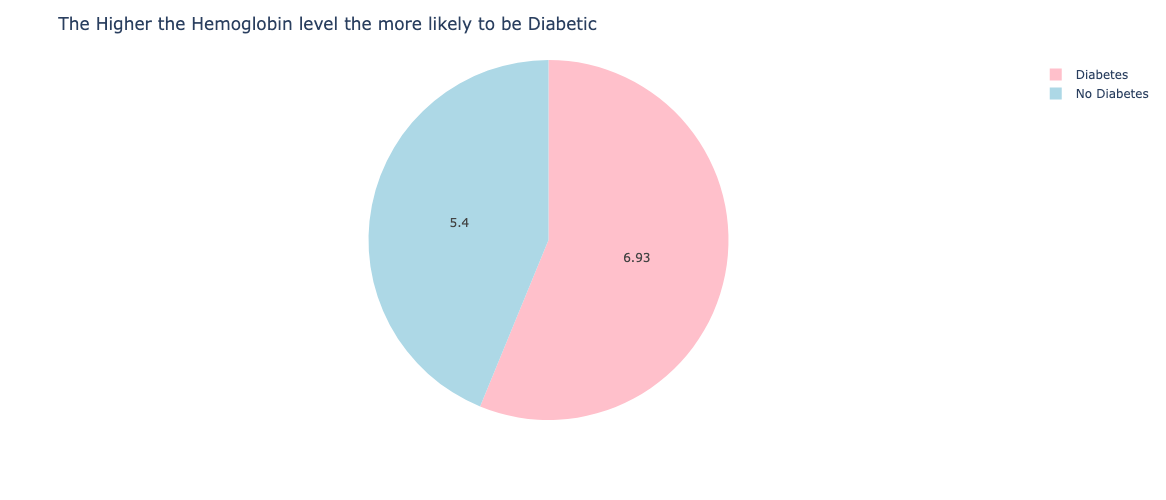

In [152]:
fig = px.pie(hba_diab_count.round(2), values="HbA1c_level", names=hba_diab_count.index, color_discrete_sequence=["pink", "lightblue"])
fig.update_layout(width=700, height=500, title_text="The Higher the Hemoglobin level the more likely to be Diabetic")
fig.update_traces(textposition='inside', textinfo='value')


### 1.1.4 Blood Glucose Level Bivariate With Diabetes 

#### T-Test and Finding the Confidence Interval For Blood Glucose Level For both Groups of Diabetes and Non-Diabetes 

**Testing whether the mean blood glucose level differs between people with diabetes (`bg_diabetes`) and those without diabetes (`bg_no_diabetes`).**

### t-statistic:

The t-statistic is a measure of how many standard errors the sample means of the two groups are apart. A larger absolute value of the t-statistic indicates that the difference between the means is more significant.

- **t-statistic: 146.16**: The t-statistic is very high, indicating that the means of blood glucose levels in the two groups are significantly different from each other.

### p-value:

The p-value is a measure of the evidence against the null hypothesis, which in this case is that there's no difference between the two groups.

- **p-value: 0.0**: A p-value of 0.0 means that the likelihood of observing such extreme differences between the groups under the assumption that they are the same (the null hypothesis) is virtually zero. 

### Summary:

Given the high t-statistic and the p-value of nearly zero, we can confidently reject the null hypothesis. This means that there is a statistically significant difference in the mean blood glucose levels between people with diabetes and those without diabetes in your dataset.

You would generally proceed to examine the means of each group to determine the direction of this difference (i.e., whether people with diabetes have higher or lower blood glucose levels compared to those without diabetes).

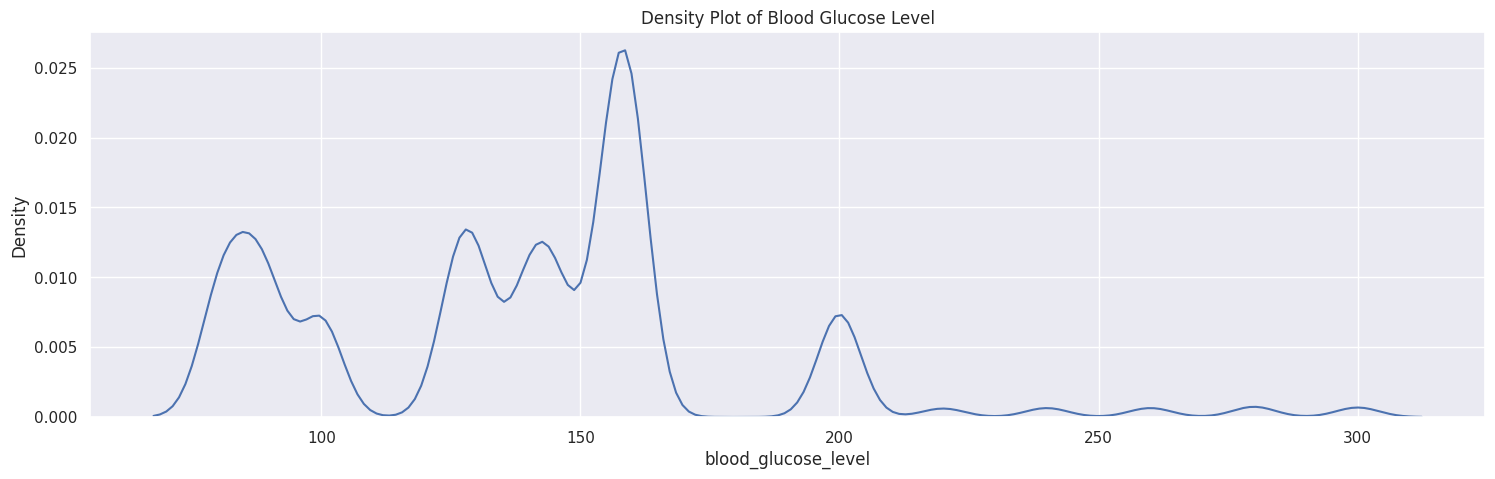

In [154]:
fig = sns.kdeplot(df, x="blood_glucose_level");
fig.set_title("Density Plot of Blood Glucose Level");

In [123]:

bg_diabetes = df.query("diabetes == 1")["blood_glucose_level"]
bg_no_diabetes = df.query("diabetes == 0")["blood_glucose_level"]


t_statistic, p_value, confidence_interval = stat_testing(bg_diabetes, bg_no_diabetes)

print()
print("-"*50)
print('t-statistic:', round(t_statistic, 2))
print('p-value:', p_value)
print("Confidence interval:", confidence_interval)
print("-"*50)
print()


--------------------------------------------------
t-statistic: 145.3
p-value: 0.0
Confidence interval: [59.94, 62.48]
--------------------------------------------------



In [20]:
glc_diab_count = df.groupby("diabetes")[["blood_glucose_level"]].mean()

glc_diab_count.index = np.where(glc_diab_count.index == 0, "No Diabetes", "Diabetes")

glc_diab_count.round(2)

,blood_glucose_level
No Diabetes,132.85
Diabetes,194.09


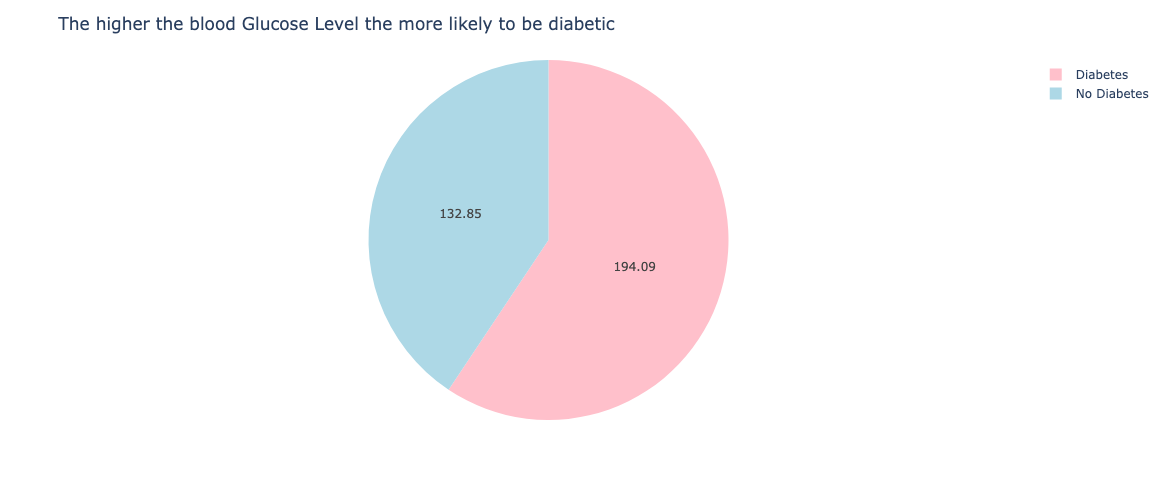

In [153]:
fig = px.pie(glc_diab_count.round(2), values="blood_glucose_level", names=glc_diab_count.index, color_discrete_sequence=["pink", "lightblue"])
fig.update_layout(width=700, height=500, title_text="The higher the blood Glucose Level the more likely to be diabetic")
fig.update_traces(textposition='inside', textinfo='value')



## 1.2 Data Preproccesing 

In [22]:
# checking how balance the Data is 


df.diabetes.value_counts(normalize=True)

0    0.915
1    0.085
Name: diabetes, dtype: float64

**As shown above, the dataset is highly imbalanced**

In [23]:
# Checking the duplicates

df.duplicated().value_counts()

False    96146
True      3854
dtype: int64

In [24]:
# Dropping the Duplicates

df.drop_duplicates(inplace=True)

### 1.2.1 Replacing No Info in smoking_histroy to NaN and we will Impute them with `most_frequent`

<p style="font-size:30px; color:red">In Medical Data Imputing is not recommended </p>

In [25]:
df["smoking_history"] = df["smoking_history"].replace("No Info", np.nan)

In [26]:
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,NaN,27.32,6.6,80,0


In [27]:
df.isnull().sum()

gender                     0
age                        0
hypertension               0
heart_disease              0
smoking_history        32887
bmi                        0
HbA1c_level                0
blood_glucose_level        0
diabetes                   0
dtype: int64

### 1.2.2 Imputing the NaNs with `most_frequent`

In [28]:
imputer = SimpleImputer(strategy="most_frequent")

smoking_imputed = imputer.fit_transform(df[["smoking_history"]])
df.smoking_history = smoking_imputed
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

## 1.3 Models

1. **LogisticRegression** 
2. **DecisionTreeClassifier** 
3. **RandomForest** 
4. **XGBoost**
5. **AdaBoost**
6. **GradianBoost**
7. **GaussianNB**



In [29]:
X = df.drop(columns="diabetes")
y = df["diabetes"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

### 1.3.1 Creating Dummy Model For Bench Mark

In [31]:
dummy = DummyClassifier()

In [32]:
dummy.fit(X_train, y_train)

# accuracy score
print("The accuracy of the dummy classifier for train is {:.2%}".format(dummy.score(X_train, y_train)))
print("The accuracy of the dummy classifier for test is {:.2%}".format(dummy.score(X_test, y_test)))

The accuracy of the dummy classifier for train is 91.21%
The accuracy of the dummy classifier for test is 91.05%


>> Based what we saw above 91.5% of the data in one class and the rests are in another class.

### 1.3.2 Model's Grid Hyperparameters

In [33]:
# Decision Tree Hyperparameters
dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__splitter': ['best', 'random'],
    'dt__max_depth': [None, 10, 20, 30, 40, 50],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 5, 10],
    'dt__max_features': [None, 'sqrt', 'log2'],
}


# RandomForest Hyperparameters 
rfc_param_grid = {
    'rfc__n_estimators': np.arange(10, 200, 10),
    'rfc__max_features': ['sqrt'],
    'rfc__max_depth': np.arange(1, 20),
    'rfc__bootstrap': [True, False],
    'rfc__criterion': ['gini', 'entropy'],
    # 'rfc__min_samples_split': [2, 5, 10],
    # 'rfc__min_samples_leaf': [1, 2, 4],
}

# Support Vector Mechine Hyperparameters
svc_param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    # 'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    # 'svc__degree': [2, 3, 4, 5],  # Only used when kernel is 'poly'
    # 'svc__coef0': [0, 1, 2, 3],  # Useful for 'poly' and 'sigmoid'
    # 'svc__shrinking': [True, False],
}

# LogistcRegression Hyperparameters
lgr_param_grid = {
    'lgr__C': [100, 10, 1.0, 0.1, 0.01],
    'lgr__solver': ['newton-cg', 'lbfgs', 'saga', 'sag'],
    'lgr__penalty': ['l2']
}


xgb_param_grid = {
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [4, 5, 6],
    # 'xgb__min_child_weight': [1, 2, 3],
    # 'xgb__gamma': [0, 0.1, 0.2],
    # 'xgb__subsample': [0.8, 0.9, 1.0],
    # 'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__objective': ['binary:logistic']
}



xgbrf_param_grid = {
    'xgbrf__n_estimators': [100, 200, 300],  # Number of boosted trees to fit
    'xgbrf__max_depth': [3, 5, 7, 10],       # Maximum tree depth for base learners
    'xgbrf__learning_rate': [0.01, 0.05, 0.1], # Boosting learning rate (xgb's "eta")
    # 'xgbrf__subsample': [0.7, 0.8, 0.9, 1], # Subsample ratio of the training instance
    # 'xgbrf__colsample_bytree': [0.7, 0.8, 0.9, 1],  # Subsample ratio of columns when constructing each tree
    # 'xgbrf__min_child_weight': [1, 2, 3],   # Minimum sum of instance weight(hessian) needed in a child
    # 'xgbrf__gamma': [0, 0.1, 0.2],           # Minimum loss reduction required to make a further partition
    # 'xgbrf__scale_pos_weight': [0.5, 1, 2],  # Balancing of positive and negative weights
    # 'xgbrf__reg_alpha': [0, 0.1, 0.5],       # L1 regularization term on weights
    # 'xgbrf__reg_lambda': [1, 1.5, 2]        # L2 regularization term on weights
}


adaboost_params = {
    'ada__n_estimators': [10, 50, 100, 200],
    'ada__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

gradientboost_params = {
    'grb__n_estimators': [10, 50, 100, 200],
    'grb__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    # 'grb__subsample': [0.5, 0.8, 1.0],
    'grb__max_depth': [3, 4, 5, 6, 7],
    # 'grb__min_samples_split': [2, 3, 4],
    # 'grb__min_samples_leaf': [1, 2, 3]
}

gaussiannb_params = {
    'gnb__var_smoothing': [1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
}

### 1.3.3 Column Transformers, Pipeline and GridSearchCV 

* Standardizing the `"age", "bmi", "HbA1c_level", "blood_glucose_level"`
* Applying PolynomialFeatures to the Standardized Columns 
* Applying OneHotEncoding to `"gender"`
* Since this dataset is highly imbalaced, Using `SMOTE` technique to create a balanced class on training dataset. (This technique will increase the number of minority classes)
* Applying the above the GridSearchCV with 5 Cross Validation with `recall` Scoring 


In [124]:
    
poly_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ("poly", PolynomialFeatures(include_bias=False, degree=3))
])

no_poly_pipe = Pipeline([
    ('scaler', StandardScaler()), 
])


col_transformer_poly = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary"), ["gender", "smoking_history"]),
    ('poly_pipe', poly_pipe, ["age", "bmi", "HbA1c_level", "blood_glucose_level"])
])


def randomized_search(scoring, param_grid, name_step, model):
    pipe = Pipeline([
        ("transformer", col_transformer_poly),
        ('smote', SMOTE(random_state=42)),
        (name_step, model)
    ])   
    return GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring)



In [35]:


models = [
    {"lgr_model": randomized_search("recall", lgr_param_grid, "lgr", LogisticRegression(max_iter=200000))},
    
    {"dt_model": randomized_search("recall", dt_param_grid, "dt", DecisionTreeClassifier())},
    
    {"rfc_model": randomized_search("recall", rfc_param_grid, "rfc", RandomForestClassifier())},
    
    {"xgb_model": randomized_search("recall", xgb_param_grid, "xgb", xgb.XGBClassifier(eval_metric="error"))},
    
    {"xgbrf_model": randomized_search("recall", xgbrf_param_grid, "xgbrf", xgb.XGBRFClassifier())},
    
    {"ada_model": randomized_search("recall", adaboost_params, "ada", AdaBoostClassifier())},
    
    {"grb_model": randomized_search("recall", gradientboost_params, "grb", GradientBoostingClassifier())},
    
    {"gnb_model": randomized_search("recall", gaussiannb_params, "gnb", GaussianNB())},

]

        

### 1.3.4 Recall and Percision Plotting Function 

In [36]:
def precision_thresh(predict_probs, y, thresh):
    preds = np.where(predict_probs >= thresh, 1, 0)
    return precision_score(y, preds, pos_label=1)

def recall_thresh(predict_probs, y, thresh):
    preds = np.where(predict_probs >= thresh, 1, 0)
    return recall_score(y, preds, pos_label=1)


def plot_recall_precision(Xtest, ytest, model, title):
    prob_table = model.predict_proba(Xtest)[:, 1]
    thresholds = np.arange(0, 1, .05)
    results_df = pd.DataFrame({'threshold': thresholds, 'precision': [precision_thresh(prob_table, ytest, i) for i in thresholds]})
    results_df['recall'] = [recall_thresh(prob_table, ytest, i) for i in thresholds]
    
    plt.figure(figsize=(12, 3))
    plt.plot(results_df['threshold'], results_df['precision'], '--o', label='Precision')
    
    plt.plot(results_df['threshold'], results_df['recall'], '--o', label='Recall', lw=2)
    plt.legend()
    plt.xticks(thresholds)
    plt.xlabel('Threshold')
    plt.ylabel('Precision and Recall')
    plt.title(title)
    plt.grid();

### 1.3.5 Training The Models and Saving them

```python
for i in models:
    try:
        for model_name, model in i.items():
            model = model.fit(X_train, y_train)
            filename = f'trained_models/{model_name}.sav'
            dump(model, filename)
    except Exception:
        traceback.print_exc()
        pass
```

### 1.3.6 Loading the Models 

In [37]:
import os
files = os.listdir("trained_models/")


models_dict = {}
for file in files:
    key = file.strip().split(".")[0]
    if key:
        model = load(f"trained_models/{file}")
        models_dict[key] = model


In [38]:
model_keys = list(models_dict.keys())

In [39]:
lgr_model = models_dict["lgr_model"]
rfc_model = models_dict["rfc_model"]
dt_model = models_dict["dt_model"]
xgb_model = models_dict["xgb_model"]
ada_model = models_dict["ada_model"]
grb_model = models_dict["grb_model"]
gnb_model = models_dict["gnb_model"]


In [40]:
lgr_preds = lgr_model.predict(X_test)
rfc_preds = rfc_model.predict(X_test)
dt_preds  = dt_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
ada_preds = ada_model.predict(X_test)
grb_preds = grb_model.predict(X_test)
gnb_preds = gnb_model.predict(X_test)


### 1.3.7 Extracting `True Negative`, `False Positive`, `False Negative`, and `True Positive` of All Models

In [41]:
from sklearn.metrics import confusion_matrix

lgr_cm = confusion_matrix(y_test, lgr_preds)
rfc_cm = confusion_matrix(y_test, rfc_preds)
dt_cm = confusion_matrix(y_test, dt_preds)
xgb_cm = confusion_matrix(y_test, xgb_preds)
ada_cm = confusion_matrix(y_test, ada_preds)
grb_cm = confusion_matrix(y_test, grb_preds)
gnb_cm = confusion_matrix(y_test, gnb_preds)


lgr_TN, lgr_FP, lgr_FN, lgr_TP = lgr_cm.ravel()
rfc_TN, rfc_FP, rfc_FN, rfc_TP = rfc_cm.ravel()
dt_TN, dt_FP, dt_FN, dt_TP = dt_cm.ravel()
xgb_TN, xgb_FP, xgb_FN, xgb_TP = xgb_cm.ravel()
ada_TN, ada_FP, ada_FN, ada_TP = ada_cm.ravel()
grb_TN, grb_FP, grb_FN, grb_TP = grb_cm.ravel()
gnb_TN, gnb_FP, gnb_FN, gnb_TP = gnb_cm.ravel()

In [125]:
confusion_matrix_df = pd.DataFrame({
    "True Negative": [lgr_TN, rfc_TN, dt_TN, xgb_TN, ada_TN, grb_TN, gnb_TN],
    "False Positive": [lgr_FP, rfc_FP, dt_FP, xgb_FP, ada_FP, grb_FP, gnb_FP], 
    "False Negative": [lgr_FN, rfc_FN, dt_FN, xgb_FN, ada_FN, grb_FN, gnb_FN],
    "True Positive": [lgr_TP, rfc_TP, dt_TP, xgb_TP, ada_TP, grb_TP, gnb_TP], 
}, index=["LogisticRegression", "RandomForest", "DecisionTree", "XGBosst", "AdaBoost", "GradientBoost", "GaussianNB"])


confusion_matrix_df.sort_values(by="False Negative")

,True Negative,False Positive,False Negative,True Positive
AdaBoost,14693,2816,106,1615
GradientBoost,13840,3669,130,1591
LogisticRegression,15443,2066,135,1586
XGBosst,15175,2334,158,1563
DecisionTree,15391,2118,176,1545
RandomForest,16324,1185,259,1462
GaussianNB,16363,1146,655,1066


### 1.3.8 Plotting the Recall and Precision of all Models

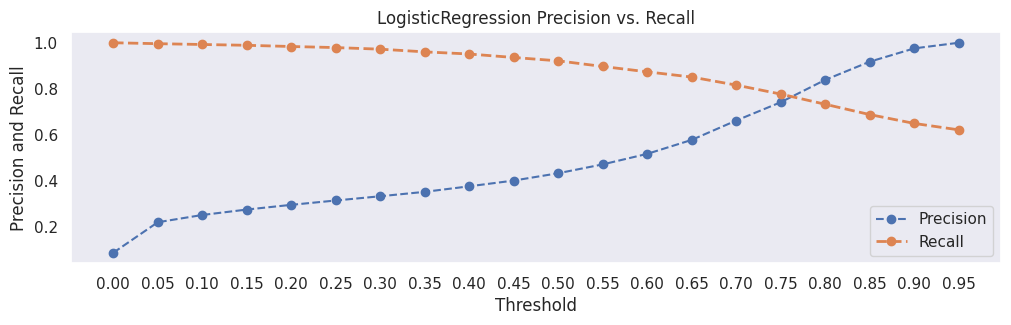

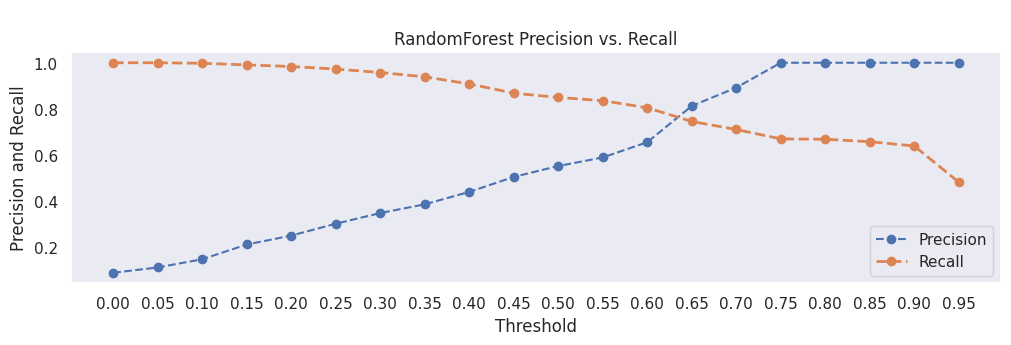

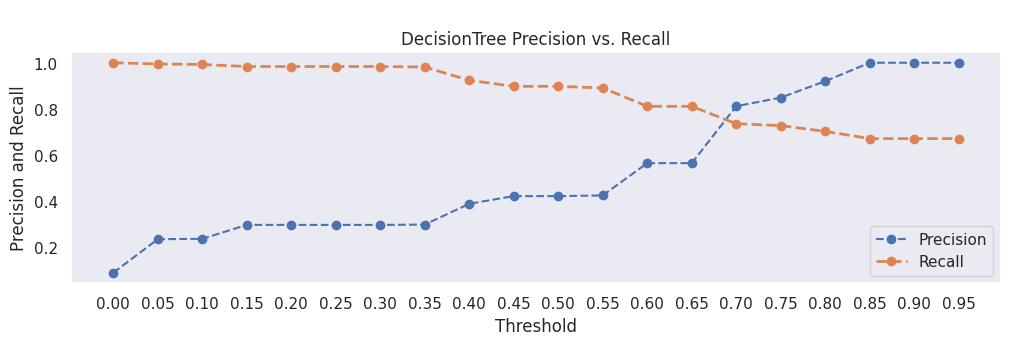

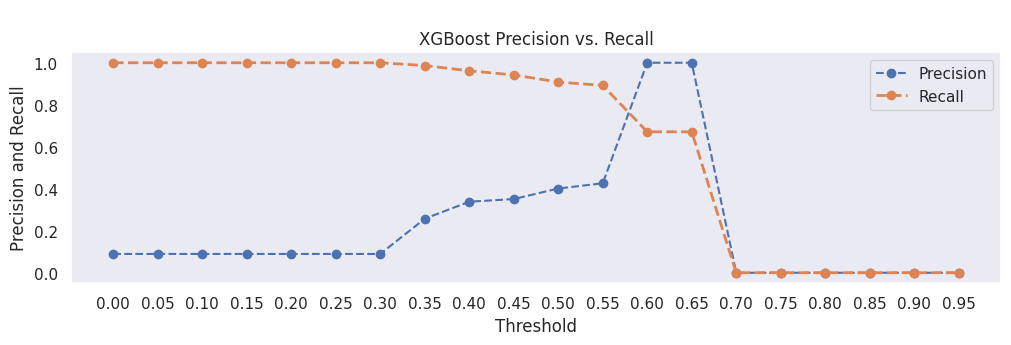

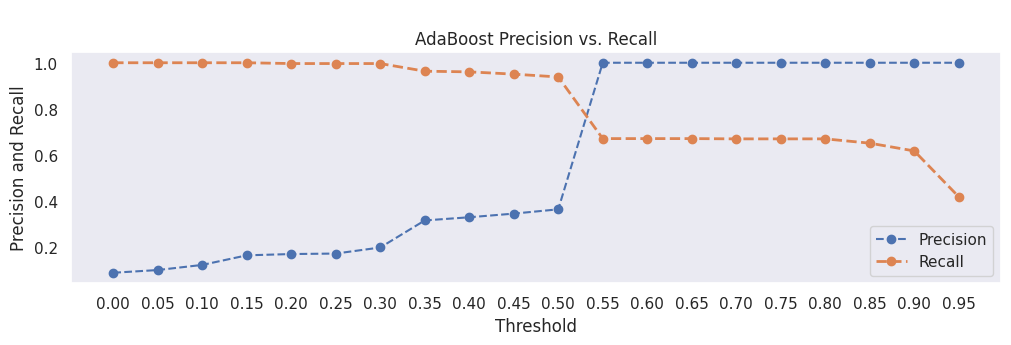

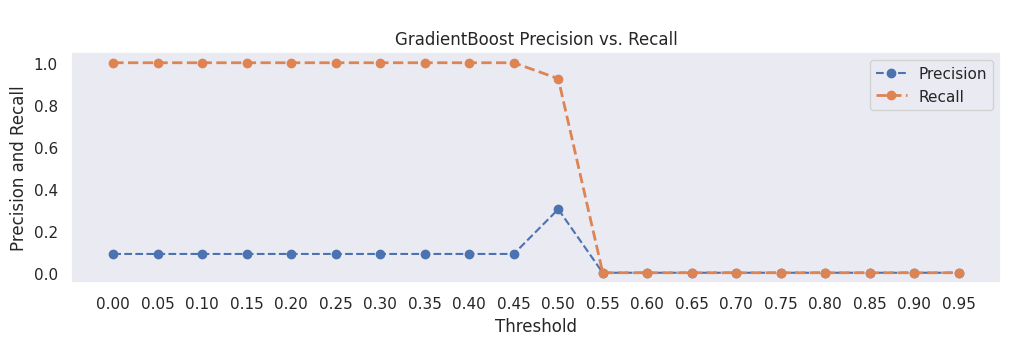

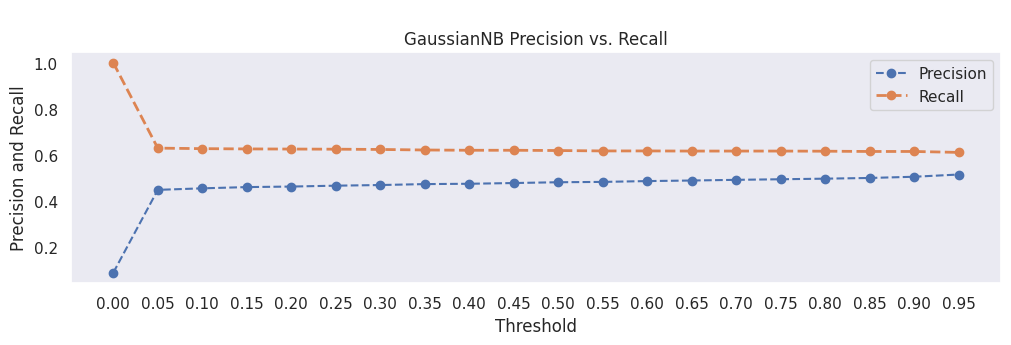

In [43]:
plot_recall_precision(X_test, y_test, lgr_model, "LogisticRegression Precision vs. Recall")
plot_recall_precision(X_test, y_test, rfc_model, "\nRandomForest Precision vs. Recall")
plot_recall_precision(X_test, y_test, dt_model, "\nDecisionTree Precision vs. Recall")
plot_recall_precision(X_test, y_test, xgb_model, "\nXGBoost Precision vs. Recall")
plot_recall_precision(X_test, y_test, ada_model, "\nAdaBoost Precision vs. Recall")
plot_recall_precision(X_test, y_test, grb_model, "\nGradientBoost Precision vs. Recall")
plot_recall_precision(X_test, y_test, gnb_model, "\nGaussianNB Precision vs. Recall")




### 1.3.9 Analyzing Model Performance:

<hr>

1. **RandomForest** and **GaussianNB** have the highest number of True Negatives (16324 and 16363 respectively), indicating that they are quite good at identifying the negative class. However, RandomForest has a lower number of False Negatives and more True Positives compared to GaussianNB.

2. **LogisticRegression** and **DecisionTree** have balanced performance with a lower number of False Positives (2066 and 2118, respectively) compared to other models like AdaBoost and GradientBoost.

3. **AdaBoost** and **GradientBoost** have a higher number of False Positives (2816 and 3669, respectively), meaning they are more likely to misclassify negative instances as positive.

4. **GaussianNB** has a significantly higher number of False Negatives (655), meaning it's not as effective at capturing positive instances as the other models.

### Sensitivity (Recall):

- If identifying True Positives is critical, then **AdaBoost** and **GradientBoost** do the best job, as they have the highest numbers of True Positives (1615 and 1591).

### Specificity:

- If avoiding False Positives is important, then **RandomForest** and **GaussianNB** are your best bet, with RandomForest slightly edging out due to a lower number of False Positives (1185 vs 1146).

### Balanced Performance:

- **LogisticRegression** seems to provide a more balanced performance, with a high number of True Negatives and a comparatively lower number of False Positives.

### Error Rates:

- **GradientBoost** has the highest number of False Positives (3669), making it more prone to Type I errors.
- **GaussianNB** has the highest number of False Negatives (655), making it more prone to Type II errors.

Note: This is a simplistic analysis. It's often good to look at other metrics like F1 Score, ROC AUC, and precision-recall curves for a more complete picture.


### Reducing False Negative
In a medical context like diabetes diagnosis, reducing False Negatives (FN) is crucial because a FN means that a patient who actually has diabetes is wrongly classified as not having it, which could lead to a lack of treatment and severe health risks. Here's how the models fare in terms of minimizing FN:

### False Negatives (Lower is Better):
1. **AdaBoost**: 106
2. **LogisticRegression**: 135
3. **GradientBoost**: 130
4. **XGBoost**: 158
5. **DecisionTree**: 176
6. **RandomForest**: 259
7. **GaussianNB**: 655

**AdaBoost** has the lowest number of False Negatives (106), followed closely by **LogisticRegression** and **GradientBoost**. This makes these models the most suitable for minimizing the risk of missing actual positive cases of diabetes.

### Trade-offs:

1. **AdaBoost**: Even though it has the lowest FN, it has a higher number of False Positives (2816). Depending on the application, the cost of FP might be worth the gain in reducing FN.

2. **RandomForest** and **GaussianNB**: They have excellent True Negative counts but are the worst performers in terms of FN. For a medical application, these might not be the best choices.

3. **LogisticRegression**: Provides a balanced performance but still has room for improvement in reducing FN.

### Recommendations:

1. **Fine-Tuning**: For the models with the lowest FN, like AdaBoost, you could consider fine-tuning hyperparameters to see if you can reduce FN even more without significantly affecting other metrics.
   
2. **Cost-Sensitive Learning**: Implement cost-sensitive learning where the misclassification cost for FN is higher than for FP.

3. **Ensemble Methods**: Combining predictions from models that have low FN could potentially result in an even lower overall FN.

4. **Class Weighting or Resampling**: Given the importance of correctly identifying positive cases, using techniques like class weighting or oversampling the positive class could also be helpful.

5. **Additional Features or Data**: Sometimes additional information can help the model better separate the classes.

Remember that in medical contexts, it's not only about the model's statistical performance but also about how clinicians will use this information. Therefore, domain expertise is crucial in interpreting these results.

## 2.0 Selecting the Best Model

based on the analysis done above, and the number of False Negatives, I have decided to select `AdaBoost` as my best model for prediction 



### 2.1 Extracting AdaBoost Feature Importance

In [51]:
best_estimator = ada_model.best_estimator_
ada = ada_model.best_estimator_.named_steps["ada"]
feature_importances = ada.feature_importances_
transformer = best_estimator.named_steps['transformer']

ohe_features = transformer.named_transformers_['ohe'].get_feature_names_out(['gender', 'smoking_history'])

poly_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']  # your original numerical columns

from itertools import combinations_with_replacement
all_poly_terms = []
for length in range(1, 4):  # your polynomial degree is 3
    for subset in combinations_with_replacement(poly_features, length):
        all_poly_terms.append("*".join(subset))


all_feature_names = list(ohe_features) + all_poly_terms

df_feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)


In [59]:
df_feature_importance.head()

,Feature,Importance
22,age*age*age,0.23
24,age*age*HbA1c_level,0.19
40,HbA1c_level*blood_glucose_level*blood_glucose_...,0.16
14,age*HbA1c_level,0.12
8,age,0.11


In [56]:
important_features = df_feature_importance.query("Importance != 0.00")

<AxesSubplot: xlabel='Importance', ylabel='Feature'>

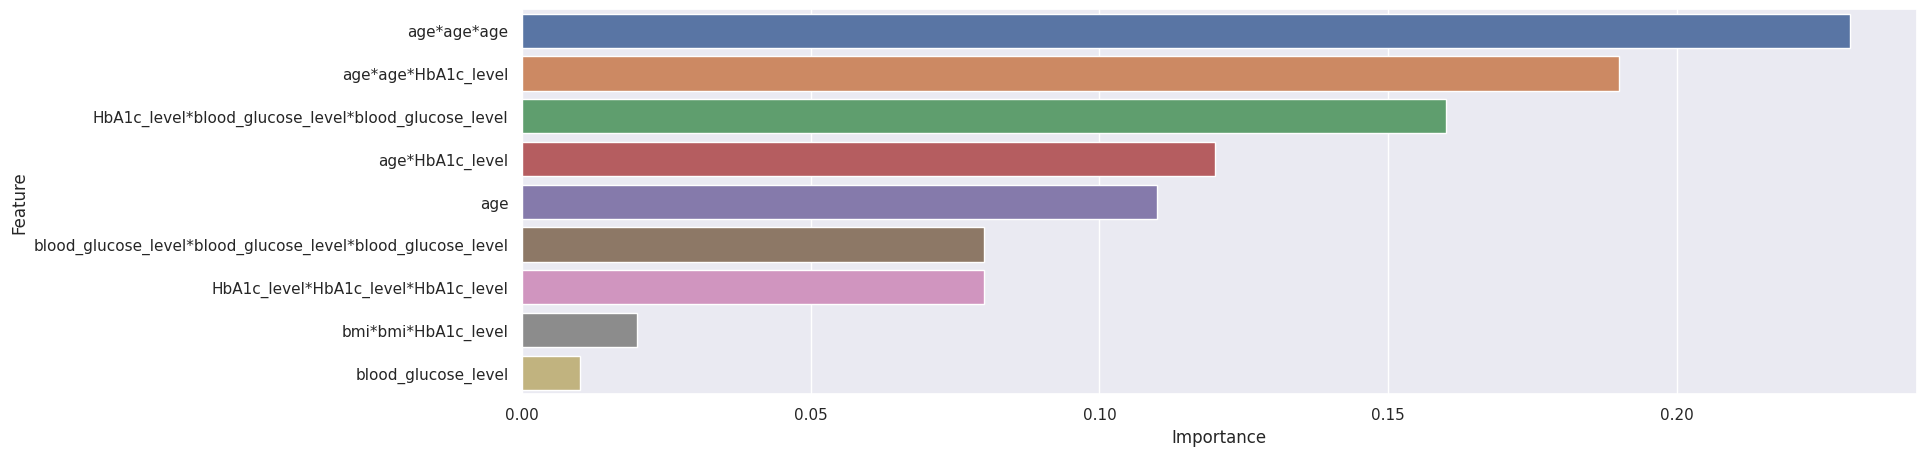

In [58]:
sns.barplot(data=important_features, y="Feature", x="Importance")

### 2.2 Explaining the Coefficients of AdaBoost Model

1. **`age*age*age` (0.23)**: This is the cubic term for age. It has the highest importance score of 0.23, indicating it is the most influential factor according to this AdaBoost model. A high score suggests that as the age varies, it has a considerable impact on the model's decision-making process.

2. **`age*age*HbA1c_level` (0.19)**: This is an interaction term between the square of age and the HbA1c level. The high importance score of 0.19 suggests that the interaction between these features is significantly associated with the target outcome.

3. **`HbA1c_level*blood_glucose_level*blood_glucose_level` (0.16)**: This term shows interaction between the HbA1c level and the square of blood glucose level. With a score of 0.16, it's also considered an important factor in the model's predictions.

4. **`age*HbA1c_level` (0.12)**: This is an interaction term between age and the HbA1c level. It signifies that the relationship between these two variables is important for the model's decision-making, but less so compared to the higher-ranking features.

5. **`age` (0.11)**: This is the age feature, with a score of 0.11, which indicates that age alone is also an important factor for the model.

6. **`blood_glucose_level*blood_glucose_level*blood_glucose_level` (0.08)**: This is the cubic term for blood glucose level. It has a moderate importance score of 0.08, suggesting that it still has some influence on the model's outcome.

7. **`HbA1c_level*HbA1c_level*HbA1c_level` (0.08)**: This is the cubic term for HbA1c level, also with a score of 0.08, which shows that it plays a role in the model's prediction but is not as crucial as some other features.

8. **`bmi*bmi*HbA1c_level` (0.02)**: This is an interaction term between the square of BMI and HbA1c level. With a lower importance score of 0.02, it has a comparatively minor impact on the model's decision.

9. **`blood_glucose_level` (0.01)**: This is the blood glucose level, and its very low score of 0.01 suggests that it doesn't contribute much to the model's prediction when considered alone.


## 3.0 Testing the Model with Test Patient 

**Useing `predict_proba()` to determine the percentage of the patient being wether in Diabetes Class or not**

In [76]:
test_patient = pd.DataFrame(columns=[
    "gender", 
    "age",
    "hypertension",
    "heart_disease",
    "smoking_history",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level"
], index=[0])

In [79]:
test_patient["gender"] = "Male"
test_patient["hypertension"] = 1
test_patient["heart_disease"] = 0
test_patient["age"] = 40
test_patient["blood_glucose_level"] = 140
test_patient["HbA1c_level"] = 6
test_patient["bmi"] = 67
test_patient["smoking_history"] = "never"


In [80]:
test_patient

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Male,40,1,0,never,67,6,140


In [81]:
ada_preds = ada_model.predict_proba(test_patient)
ada_preds

array([[0.60210462, 0.39789538]])

In [126]:

# Probability that the entry belongs to the diabetic class
risk_percentage = ada_preds[0][1] * 100

# Interpretation
if risk_percentage == 0:
    print("You Are Not Diabetic.\n\n")
    
elif risk_percentage == 100:
    print("You Are Diabetic.\n\n")
    
elif 100 > risk_percentage > 50:
    print(f"You have a high risk of {risk_percentage:.2f}% of becoming diabetic.\n\n")
    
elif 50 > risk_percentage > 0:
    print(f"You have a low risk of {risk_percentage:.2f}% of becoming diabetic.\n\n")



You have a low risk of 39.79% of becoming diabetic.


